# Homework 7: Exploring and Analyzing the Pinal County MODFLOW Model

## Introduction

In this assignment, you will work with a real-world, professional groundwater model from the Arizona Department of Water Resources (ADWR). As you know, the Pinal County model represents the Pinal Active Management Area in central Arizona and includes:
- 3 layers (vs 1 layer in tutorials), plus much larger spatial extent
- Monthly stress periods tracking transient pumping impacts
- Real pumping data from wells across the basin

## Learning Objectives

By completing this assignment, you will:
1. Load and inspect a large, multi-layer, transient groundwater model
2. Visualize model input parameters including hydraulic conductivity and well locations
3. Run the model and verify successful execution
4. Evaluate temporal changes in hydraulic head at specific locations

## The Model

You have been provided with **`PM_AWS2019_SS25115.nam`** in the `model_input_directory` folder, which includes (among many other files):
- WEL (Well) package with pumping wells
- LPF (Layer Property Flow) package with spatially-variable hydraulic conductivity
- RCH (Recharge) and EVT (Evapotranspiration) packages
- CHD (Constant Head) boundaries representing regional flow
- 194 stress periods 

You will first explore the model structure (visualizing K, wells), then run the simulation, and finally analyze the results to understand how pumping affects the aquifer.

## Setup: Import Required Packages

In [1]:
import os
import flopy
import matplotlib.pyplot as plt
import numpy as np

# Part 1: Load and Explore the Model

Following the pattern from Tutorial 2, you will:
1. Load the model from its namelist file
2. Explore the model structure by visualizing key input parameters
3. Run the model and verify successful execution

Before running a model, it's good practice to examine its structure, boundary conditions, and stresses. This helps you understand what the model represents and identify potential issues.

## 1.1: Define Paths and Model Names

In [2]:
# Path to the MODFLOW executable
modflow_path = '../../../../modflow/mf2005' 

# Unzip the model files
if os.path.exists('../../../pinal_county_model/'):
    print("Model files already unzipped.")
else:
    ! unzip ../../../pinal_county_model.zip -d ../../../

# Directory containing the original model files # NOTE: The model output will be saved in the same directory
model_input_dir = '../../../pinal_county_model/'

# Namelist file
nam_file = 'PM_AWS2019_SS25115.nam'

os.path.abspath(model_input_dir)

Model files already unzipped.


'/workspaces/hwrs564a_course_materials_JessicaCarvalho/pinal_county_model'

## 1.2: Load the Model

In [21]:
# Load the model using FloPy
print("Loading Pinal County model... (this may take a moment)")

m = flopy.modflow.Modflow.load(
    f=nam_file,               # Namelist file <---- Learn this
    exe_name=modflow_path,    # Path to MODFLOW executable
    model_ws=model_input_dir, # Model workspace (directory)
    check=False               # Skip detailed checking due to formatting quirks
)

print("Model loaded successfully!")
print(m)

Loading Pinal County model... (this may take a moment)
Model loaded successfully!
MODFLOW 3 layer(s) 196 row(s) 222 column(s) 194 stress period(s)


## Inspect the Model Packages

In [22]:
# Print model information
print("Available packages:")
print(m.get_package_list())
print("="*60)

print(f"\nModel dimensions:")
print(f"  Layers: {m.nlay}")
print(f"  Rows: {m.nrow}")
print(f"  Columns: {m.ncol}")
print(f"  Total cells: {m.nlay * m.nrow * m.ncol}")
print(f"  Stress periods: {m.nper}")
print("="*60, "\n")

# Get stress period 0 well data
wel_data_sp0 = m.wel.stress_period_data[0]
print(f"  Number of wells in first stress period: {len(wel_data_sp0)}")
print(f"  Total pumping rate (first stress period): {wel_data_sp0['flux'].sum():.2e} ft³/day")
print()

# Get the last stress period well data
well_data_last = m.wel.stress_period_data[-1]
print(f"  Number of wells in last stress period: {len(well_data_last)}")
print(f"  Total pumping rate (last stress period): {well_data_last['flux'].sum():.2e} ft³/day")


Available packages:
['DIS', 'BAS6', 'LPF', 'WEL', 'MNW2', 'MNWI', 'EVT', 'RCH', 'CHD', 'SWT', 'STR', 'HOB', 'OC', 'GMG']

Model dimensions:
  Layers: 3
  Rows: 196
  Columns: 222
  Total cells: 130536
  Stress periods: 194

  Number of wells in first stress period: 209
  Total pumping rate (first stress period): 4.20e+06 ft³/day

  Number of wells in last stress period: 209
  Total pumping rate (last stress period): 4.20e+06 ft³/day


# Create a figure showing the wells and conductivity across the model domain

Your figure should include:
- 3 subplots (one for each layer)
- Color map (using `imshow`) of hydraulic conductivity
- Well locations overlaid as points, colored by pumping rate (be sure to set `vmin` and `vmax` for the color scale)

Additionally, try looking at other stress periods to see how pumping changes over time.

In [23]:
def get_well_data_for_layer_and_stress_period(m_wel, layer, stress_period):
    """
    Helper function to extract well data for a specific layer and stress period.
    
    Parameters:
        m_wel (flopy.modflow.mfwel.ModflowWel): The well package object from the model.
        layer (int): The layer index to filter wells by.
    
    """
    wel_data = m_wel.stress_period_data[stress_period]
    return wel_data[wel_data['k'] == layer]


# Get hydraulic conductivity array - you might want to check the shape and values
# hk2 = m.lpf.hk
hk = m.lpf.hk.array
hk_min = np.nanmin(hk)
hk_max = np.nanmax(hk)

# print(hk.shape,'\n\n',hk2.shape)

print(f"Hydraulic Conductivity stats - min: {hk_min}, max: {hk_max}")
print(f"Hydraulic Conductivity array shape: {hk.shape}")
print(f"Values sample from:\n{hk[0, -25:, np.random.randint(0, hk.shape[1]-1)]}")  # Print a small sample of the array NOT WORKING


Hydraulic Conductivity stats - min: 0.0, max: 132.97000122070312
Hydraulic Conductivity array shape: (3, 196, 222)
Values sample from:
[40. 40. 40. 40. 40. 40. 40. 40. 20. 20. 20. 20. 20. 20. 40. 40. 40. 15.
 15. 15. 15. 15.  0.  0.  0.]


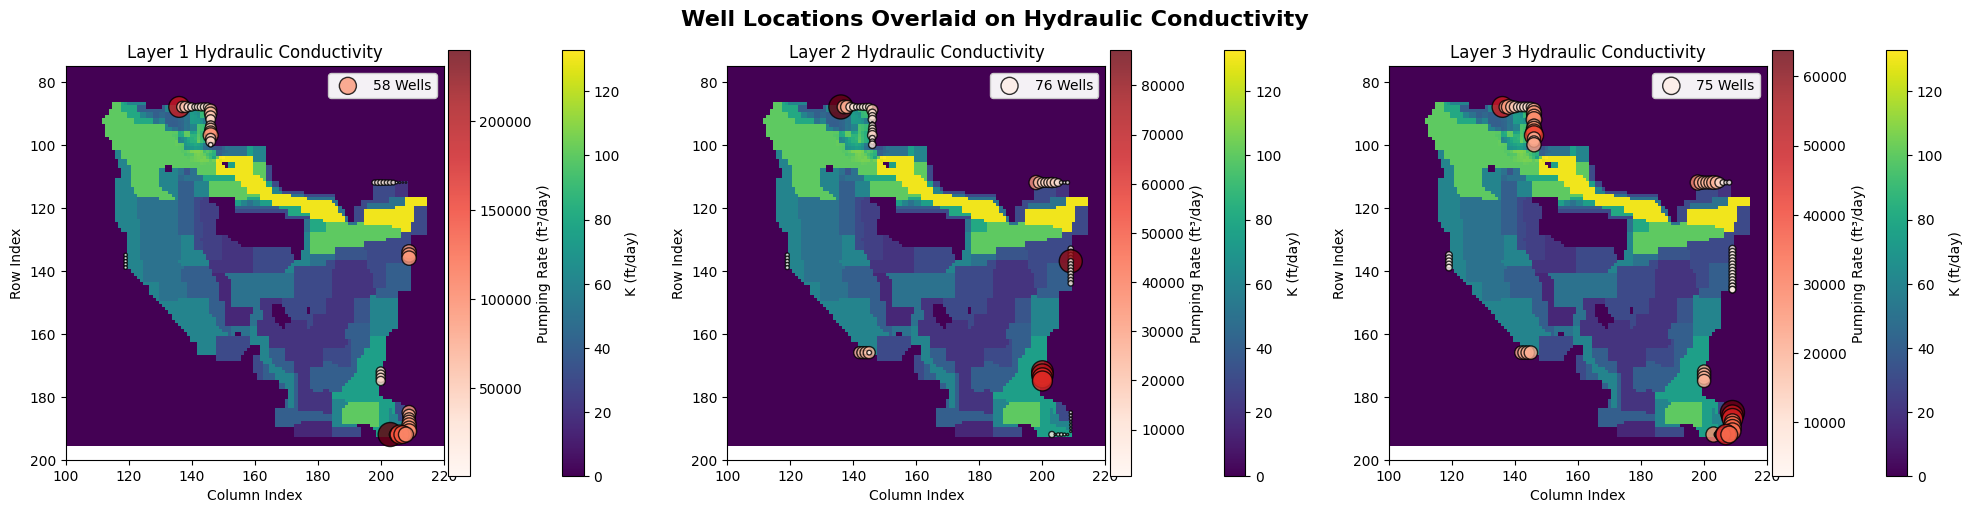

In [35]:
"""
Create 1 x 3 figure for plotting the individual layers
Use a figsize (18, 6) for decent visibility
Loop through each layer and plot
For each layer, plot the hydraulic conductivity as a background
Then overlay the well locations for that layer and stress period 0
Use scatter plot where size/color of markers represent pumping rates
Hint: Use get_well_data_for_layer_and_stress_period() to get well data for each layer
Adjust axis limits as needed for better visualization
"""

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.suptitle(f'Well Locations Overlaid on Hydraulic Conductivity', fontsize=16, fontweight='bold')

for layer_to_plot in range(hk.shape[0]):
    # Plot K field as background first
    ax = axes[layer_to_plot]
    im = ax.imshow(hk[0, :, :], origin='upper', vmin=hk_min, vmax=hk_max) # , cmap='viridis'
    # Add colorbar for K
    plt.colorbar(im, ax=ax, label='K (ft/day)', shrink=1.0, pad=0.08)

    # Get well data for this layer and stress period 0
    wells_in_layer = get_well_data_for_layer_and_stress_period(m.wel, layer_to_plot, 0)

    # Now pull out the `i`, `j`, and `flux` columns
    well_rows_layer = wells_in_layer['i']
    well_cols_layer = wells_in_layer['j']
    pump_rates_layer = wells_in_layer['flux']

    # Convert to positive values for sizing and coloring
    abs_pump_rates = np.abs(pump_rates_layer)
    # Normalize marker sizes (scale to reasonable range)
    marker_sizes = (abs_pump_rates / abs_pump_rates.max()) * 300

    # Overlay well locations
    scatter = ax.scatter(well_cols_layer, well_rows_layer, 
                         s=marker_sizes,           # Size proportional to pumping rate
                         c=abs_pump_rates,         # Color by absolute pumping rate
                         cmap='Reds',              # Red colormap
                         alpha=0.8,
                         edgecolors='black',
                         linewidths=1,
                         marker='o',
                         label=f'{len(wells_in_layer)} Wells')
    # Add colorbar for pumping rates
    cbar_wells = plt.colorbar(scatter, ax=ax, label='Pumping Rate (ft³/day)', shrink=1.0, pad=0.01)

    ax.set_title(f'Layer {layer_to_plot + 1} Hydraulic Conductivity')
    ax.set_xlabel('Column Index')
    ax.set_xlim(100, 220)  # Adjust x-axis limits as needed
    ax.set_ylabel('Row Index')
    ax.set_ylim(200, 75)  # Reverse y-axis for correct orientation
    ax.legend(loc='upper right', fontsize=10, framealpha=0.95)

plt.tight_layout()

In [25]:
# Run the model - this will take a few minutes
# Set `silent=False` to see the output, and `pause=False` to avoid waiting for user input

success, buff = m.run_model(silent=False, pause=False, report=True)

# NOTE: The model output will be saved in the same directory as the input files
# Check if the model ran successfully via the `success` flag returned by `run_model()`
if success:
    print("\n" + "="*60)
    print("Model run completed successfully!")
    print("="*60)
else:
    print("\n" + "="*60)
    print("ERROR: Model run failed!")
    print("="*60)
    raise Exception("Model run failed. Check the .list file for errors.")

FloPy is using the following executable to run the model: ../../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: PM_AWS2019_SS25115.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/11/17  3:33:24



 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Wa

## 2.3: Calculate Drawdown

Drawdown is the lowering of the water table due to pumping. It's calculated as the change from initial to final conditions:

$$\text{Drawdown} = \text{Head}_{\text{initial}} - \text{Head}_{\text{final}}$$

Positive drawdown values indicate head lowering during the simulation. For this analysis, we will focus on the first layer, but you can extend it to other layers if desired. To complete this part, you will:
1. Load the initial and final head arrays
2. Calculate the drawdown
3. Analyze the drawdown statistics (max, mean, min)
4. Make a 3 panel figure showing initial heads, final heads, and drawdown

Make sure to clearly label your plots and choose appropriate color scales/maps.

In [26]:
# Path to head file
hds_file = f'{model_input_dir}/Pinal.hds'

# Load head file
hds = flopy.utils.HeadFile(hds_file)

# Get the times - this will be used for loading initial and final heads
times = hds.get_times()

In [27]:
# Get initial heads (first time step)
missing_value = -999.00

heads_initial = hds.get_data(totim=times[0])
heads_initial[heads_initial <= missing_value] = np.nan  # Replace missing values with NaN

# Get final heads (last time step)
heads_final = hds.get_data(totim=times[-1])
heads_final[heads_final <= missing_value] = np.nan  # Replace missing values with NaN

# Print array information - this should help you understand the structure of the head data
print(f"Initial heads shape: {heads_initial.shape}")
print(f"Final heads shape: {heads_final.shape}")
print(f"\nArray dimensions: (layers, rows, columns)")
print(f"  Layers: {heads_initial.shape[0]}")
print(f"  Rows: {heads_initial.shape[1]}")
print(f"  Columns: {heads_initial.shape[2]}")

# Print basic statistics for layer 1 (index 0)
print(f"\nLayer 1 head statistics (INITIAL - Time = {times[0]:.1f} days):")
print(f"  Min: {np.nanmin(heads_initial[0, :, :]):.2f} ft")
print(f"  Max: {np.nanmax(heads_initial[0, :, :]):.2f} ft")
print(f"  Mean: {np.nanmean(heads_initial[0, :, :]):.2f} ft")

print(f"\nLayer 1 head statistics (FINAL - Time = {times[-1]:.1f} days):")
print(f"  Min: {np.nanmin(heads_final[0, :, :]):.2f} ft")
print(f"  Max: {np.nanmax(heads_final[0, :, :]):.2f} ft")
print(f"  Mean: {np.nanmean(heads_final[0, :, :]):.2f} ft")

Initial heads shape: (3, 196, 222)
Final heads shape: (3, 196, 222)

Array dimensions: (layers, rows, columns)
  Layers: 3
  Rows: 196
  Columns: 222

Layer 1 head statistics (INITIAL - Time = 1.0 days):
  Min: 1000.00 ft
  Max: 1700.50 ft
  Mean: 1318.53 ft

Layer 1 head statistics (FINAL - Time = 70493.5 days):
  Min: 931.67 ft
  Max: 1568.80 ft
  Mean: 1152.73 ft


Drawdown statistics (Layer 1):
  Maximum drawdown: 342.40 ft
  Mean drawdown: 145.46 ft
  Minimum drawdown: 0.00 ft


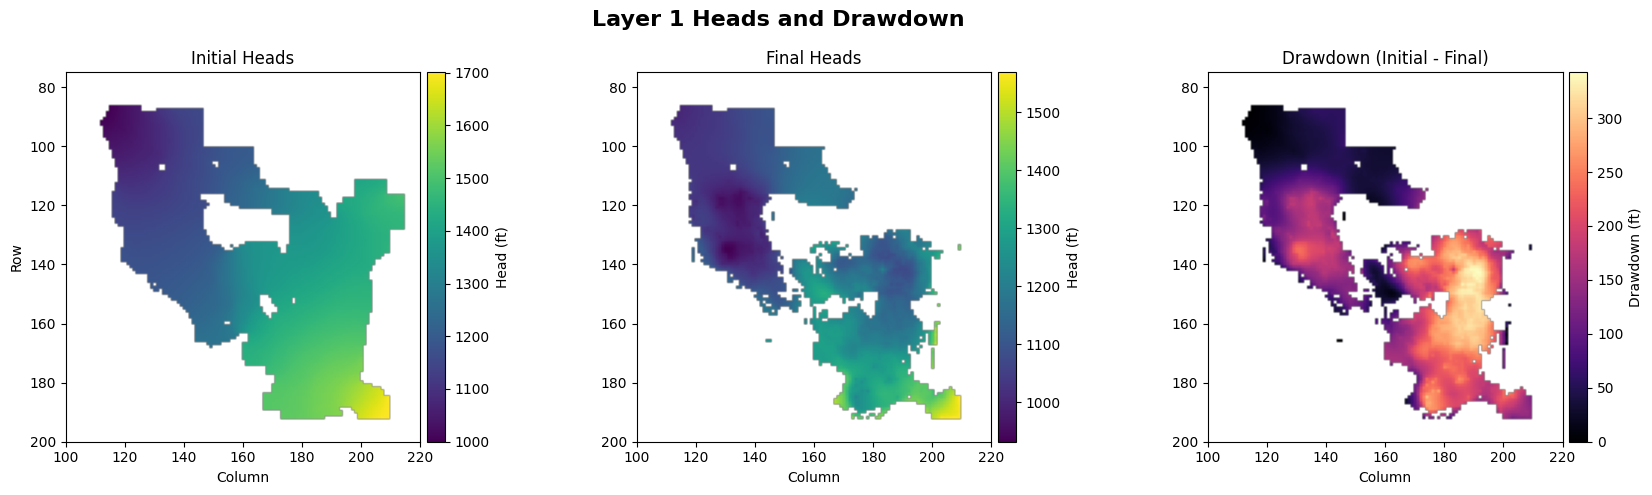

In [28]:
# Calculate drawdown (positive = head lowering)
drawdown = heads_initial - heads_final

print(f"Drawdown statistics (Layer 1):")
print(f"  Maximum drawdown: {np.nanmax(drawdown[0, :, :]):.2f} ft")
print(f"  Mean drawdown: {np.nanmean(drawdown[0, :, :]):.2f} ft")
print(f"  Minimum drawdown: {np.nanmin(drawdown[0, :, :]):.2f} ft")

# Create the figure for plotting the drawdown - use appropriate size and titles
# Create 1 x 3 figure for plotting initial heads, final heads, and drawdown
titles = 'Initial Heads', 'Final Heads', 'Drawdown (Initial - Final)'
vars = [heads_initial, heads_final, drawdown]

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(18, 5))

# Loop through each layer and plot
# For each layer, plot the hydraulic conductivity as a background
for i, _ in enumerate(axes):
    ax = axes[i]
    im = ax.imshow(vars[i][0, :, :], origin='upper', cmap='viridis' if i < 2 else 'magma')
    ax.set_title(titles[i])
    ax.set_xlabel('Column')
    ax.set_xlim(100, 220)  # Adjust x-axis limits as needed
    if i == 0:
        ax.set_ylabel('Row')
    ax.set_ylim(200, 75)  # Reverse y-axis for correct orientation
    fig.suptitle('Layer 1 Heads and Drawdown', fontsize=16, fontweight='bold')
    plt.colorbar(im, ax=ax, label='Head (ft)' if i < 2 else 'Drawdown (ft)', shrink=1.0, pad=0.01)
    plt.tight_layout()  


## Bonus: Analyze Temporal Changes in Head

To analyze how hydraulic head changes over time at specific locations, you can:
1. Select a few observation wells (or grid cells) of interest
2. Extract head values at those locations for all stress periods
3. Plot head vs. time for each location to visualize the impact of pumping

Note that this is not required, but it can provide valuable insights into the transient behavior of the system.

In [ ]:
# Sort wells by absolute pumping rate (largest first)
sorted_idx = np.argsort(-np.abs(wel_data_sp0['flux']))

# Take the top 5 wells (change this number if you want more/less)
n_wells_to_plot = 5
selected_wells = wel_data_sp0[sorted_idx[:n_wells_to_plot]]
# stress_period = np.random.randint(0, m.nper - 1)
# print(f"Selected wells (from stress period {stress_period}):")

# Print selected well information
print("Selected wells for head time series extraction:")
for idx, w in enumerate(selected_wells, start=1):
    print(f"  Well {idx}: layer={w['k']}, row={w['i']}, col={w['j']}, flux={w['flux']:.2e} ft³/day")

def get_head_time_series(hds_obj, times_list, k, i, j, missing_val=missing_value):
    """
    Extract head vs time at a single model cell (k, i, j).

    params:
        hds_obj (flopy.utils.HeadFile): HeadFile object
        times_list (list): list of times to extract heads for
        k (int): layer index
        i (int): row index
        j (int): column index
        flux (float)
    Returns:
        times (np.ndarray): list of times
        heads (np.ndarray): head at that cell for each time (NaN where inactive/missing)
    """
    heads_ts = []
    for t in times_list:
        h = hds_obj.get_data(totim=t)[k, i, j]
        # Convert missing/inactive values to NaN
        if h <= missing_val:
            heads_ts.append(np.nan)
        else:
            heads_ts.append(float(h))
    return np.array(times_list), np.array(heads_ts)


# Build a dictionary: key = label, value = (times, heads)
head_timeseries = {}
# Extract time series for each selected well
for idx, w in enumerate(selected_wells, start=1):
    k, i, j = int(w['k']), int(w['i']), int(w['j'])
    times_arr, heads_arr = get_head_time_series(hds, times, k, i, j, missing_val=missing_value)
    label = f"Well {idx} (i={i}, j={j})" # You can customize the label as needed ie"add back k"
    head_timeseries[label] = (times_arr, heads_arr)

print("\nTime series extracted for selected wells.")


Selected wells for head time series extraction:
  Well 1: layer=0, row=192, col=203, flux=2.40e+05 ft³/day
  Well 2: layer=0, row=88, col=136, flux=1.80e+05 ft³/day
  Well 3: layer=0, row=192, col=206, flux=1.49e+05 ft³/day
  Well 4: layer=0, row=192, col=207, flux=1.30e+05 ft³/day
  Well 5: layer=0, row=191, col=209, flux=9.40e+04 ft³/day



Time series extracted for selected wells.


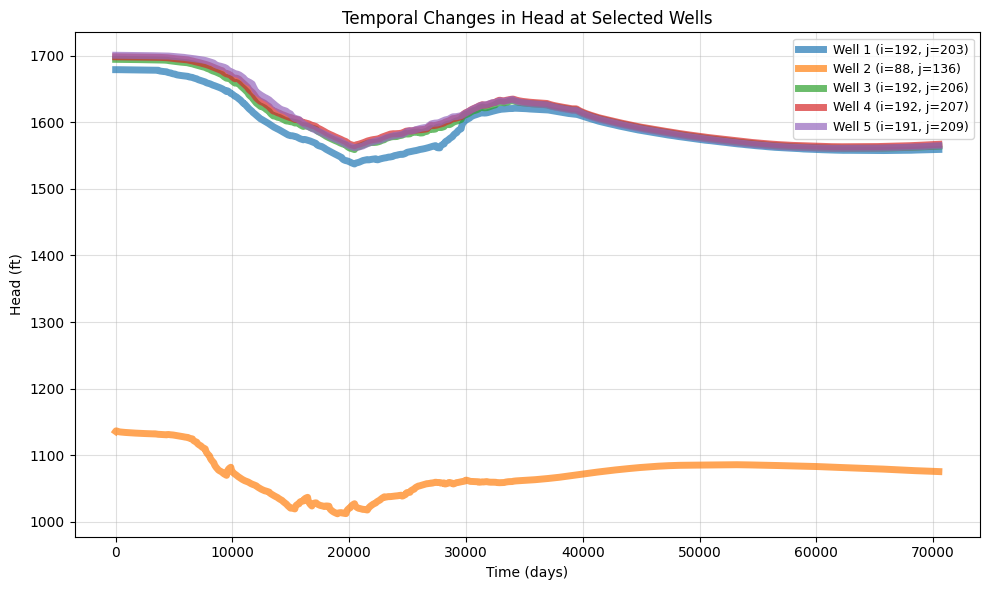

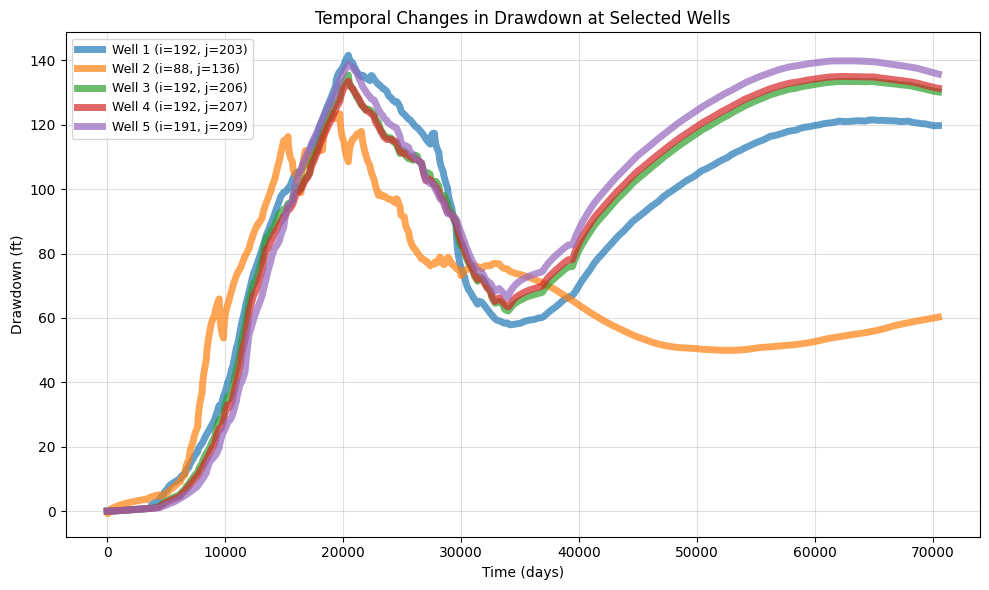

In [30]:
# Plot head vs time for the selected wells
fig, ax = plt.subplots(figsize=(10, 6))

for label, (t_arr, h_arr) in head_timeseries.items():
    ax.plot(t_arr, h_arr, linewidth=5.0, linestyle='-', alpha=0.7, label=label)

ax.set_xlabel("Time (days)")
ax.set_ylabel("Head (ft)")
ax.set_title("Temporal Changes in Head at Selected Wells")
ax.grid(True, alpha=0.4)
ax.legend(loc="best", fontsize=9)
plt.tight_layout()


# Optional: plot drawdown vs time (relative to head at first time)
fig_dd, ax_dd = plt.subplots(figsize=(10, 6))

for label, (t_arr, h_arr) in head_timeseries.items():
    # Use the first non-NaN head as the reference
    if np.all(np.isnan(h_arr)):
        continue  # skip if all values are NaN
    h0 = h_arr[~np.isnan(h_arr)][0]
    drawdown_ts = h0 - h_arr  # positive means head has declined
    ax_dd.plot(t_arr, drawdown_ts, linewidth=5.0, linestyle='-', alpha=0.7, label=label)

ax_dd.set_xlabel("Time (days)")
ax_dd.set_ylabel("Drawdown (ft)")
ax_dd.set_title("Temporal Changes in Drawdown at Selected Wells")
ax_dd.grid(True, alpha=0.4)
ax_dd.legend(loc="best", fontsize=9)
plt.tight_layout()
